In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, chi2

df = pd.read_excel('GermanCreditData.xlsx')

#show infomation of the dataset
pd.set_option('display.max_columns',None,'max_colwidth',None,'display.expand_frame_repr',False)
print('\n--- Show the number of data points (rows) and features (columns)--- \n',df.shape)
print('\n--- Information of the dataset --- \n')
print(df.info())
print('\n ---Column names of the dataset --- \n',df.columns)

print('\nBelow is the first 10 lines of the dataset......\n',df.head(10))
print('\n\nBelow is the last 5 lines of the dataset......\n',df.tail(5))

print('\nBelow is the statistics of the dataset......\n\n',df.describe())


--- Show the number of data points (rows) and features (columns)--- 
 (1000, 22)

--- Information of the dataset --- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Checking   1000 non-null   int64 
 1   Duration   1000 non-null   int64 
 2   History    1000 non-null   int64 
 3   Purpose    1000 non-null   object
 4   Amount     1000 non-null   int64 
 5   Savings    1000 non-null   int64 
 6   Emploed    1000 non-null   int64 
 7   Installp   1000 non-null   int64 
 8   marital    1000 non-null   int64 
 9   Coapp      1000 non-null   int64 
 10  Resident   1000 non-null   int64 
 11  Property   1000 non-null   int64 
 12  Age        1000 non-null   int64 
 13  Other      1000 non-null   int64 
 14  housing    1000 non-null   int64 
 15  Existcr    1000 non-null   int64 
 16  Job        1000 non-null   int64 
 17  Depends    1000 non-null   i

In [2]:
df = df[df['Purpose'] != 'X']
df['Purpose'] = df['Purpose'].astype(float)
df.drop('Bad',axis = 1, inplace = True)

<ipython-input-2-8b32f256a864>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Purpose'] = df['Purpose'].astype(float)
<ipython-input-2-8b32f256a864>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Bad',axis = 1, inplace = True)


**TASK 1**

In [3]:
subset1 = df[df['Checking'].isin([1, 2])]
subset2 = df[df['Checking'].isin([3, 4])]

In [4]:
subset1.head()

,Checking,Duration,History,Purpose,Amount,Savings,Emploed,Installp,marital,Coapp,Resident,Property,Age,Other,housing,Existcr,Job,Depends,Telephone,Foreign,Good
0,1,6,4,3.0,1169,5,5,4,3,1,4,1,67,3,2,2,3,1,2,1,1
1,2,48,2,3.0,5951,1,3,2,2,1,2,1,22,3,2,1,3,1,1,1,0
3,1,42,2,2.0,7882,1,4,2,3,3,4,2,45,3,3,1,3,2,1,1,1
4,1,24,3,0.0,4870,1,3,3,3,1,4,4,53,3,3,2,3,2,1,1,0
7,2,36,2,1.0,6948,1,3,2,3,1,2,3,35,3,1,1,4,1,2,1,1


In [5]:
subset2.head()

,Checking,Duration,History,Purpose,Amount,Savings,Emploed,Installp,marital,Coapp,Resident,Property,Age,Other,housing,Existcr,Job,Depends,Telephone,Foreign,Good
2,4,12,4,6.0,2096,1,4,2,3,1,3,1,49,3,2,1,2,2,1,1,1
5,4,36,2,6.0,9055,5,3,2,3,1,4,4,35,3,3,1,2,2,2,1,1
6,4,24,2,2.0,2835,3,5,3,3,1,4,2,53,3,2,1,3,1,1,1,1
8,4,12,2,3.0,3059,4,4,2,1,1,4,1,61,3,2,1,2,1,1,1,1
16,4,24,4,3.0,2424,5,5,4,3,1,4,2,53,3,2,2,3,1,1,1,1


**TASK 2**

In [6]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(subset1.drop(['Good'], axis=1), subset1['Good'], test_size=0.3, random_state=42)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(subset2.drop(['Good'], axis=1), subset2['Good'], test_size=0.3, random_state=42)

**TASK 3**

In [7]:
#Calculate the information value (IV) for each feature
def calc_iv(df, feature, target):

    # convert the feature back to its original data type
    original_dtype = df[feature].dtype
    if pd.api.types.is_categorical_dtype(original_dtype):
        df[feature] = df[feature].cat.codes.replace(-1, np.nan)
    
    # group the data by the feature variable
    grouped = df.groupby(feature, as_index=False)
    
    # calculate the number of observations in each group
    n_obs = grouped[target].count()
    
    # calculate the number of positive and negative cases in each group
    n_pos = grouped[target].sum()
    n_neg = n_obs - n_pos
    
    # calculate the proportions of positive and negative cases in each group
    p_pos = n_pos / n_pos.sum()
    p_neg = n_neg / n_neg.sum()
    
    # calculate the WoE for each group
    woe = np.log(p_pos / p_neg)
    
    # calculate the IV for the feature
    iv = np.sum((p_pos - p_neg) * woe)
    
    # convert the feature back to categorical if it was originally categorical
    if pd.api.types.is_categorical_dtype(original_dtype):
        df[feature] = df[feature].astype(original_dtype)
    
    return iv
    
ivs = {}
for col in df.columns:
    if col not in ['Good', 'Bad']:
        ivs[col] = calc_iv(df, col, 'Good')
        
print(ivs)

/usr/local/lib/python3.9/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


{'Checking': Checking    0.0000
Good        0.6707
dtype: float64, 'Duration': Duration    0.0
Good        inf
dtype: float64, 'History': History    0.000000
Good       0.281607
dtype: float64, 'Purpose': Purpose    0.000000
Good       0.167962
dtype: float64, 'Amount': Amount    0.0
Good      inf
dtype: float64, 'Savings': Savings    0.000000
Good       0.201328
dtype: float64, 'Emploed': Emploed    0.000000
Good       0.094201
dtype: float64, 'Installp': Installp    0.0000
Good        0.0295
dtype: float64, 'marital': marital    0.000000
Good       0.045753
dtype: float64, 'Coapp': Coapp    0.000000
Good     0.028005
dtype: float64, 'Resident': Resident    0.000000
Good        0.004582
dtype: float64, 'Property': Property    0.000000
Good        0.117151
dtype: float64, 'Age': Age     0.0
Good    inf
dtype: float64, 'Other': Other    0.00000
Good     0.05315
dtype: float64, 'housing': housing    0.000000
Good       0.089777
dtype: float64, 'Existcr': Existcr    0.000000
Good       0.

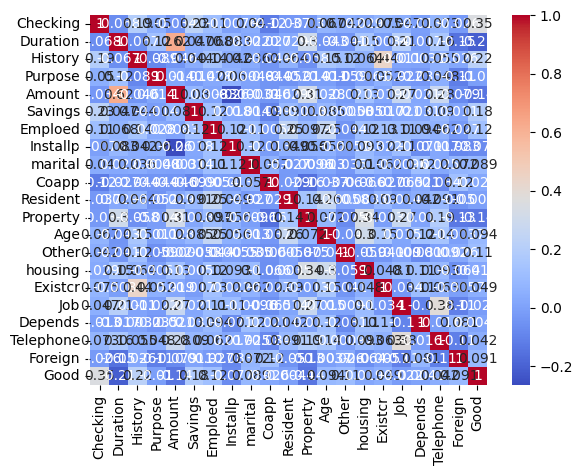

In [8]:
# calculate the correlation matrix
corr = df.corr()

# create a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')

# show the plot
plt.show()

In [9]:
# perform feature selection based on chi-quared statistical test for subset 1
model_sub1 = SelectKBest(chi2, k=5)
model_sub1.fit_transform(X_train_1, y_train_1)

dict_sub1 = {}
X_train_1_features, features_chi = list(X_train_1.columns),list(model_sub1.scores_)
for i in range(len(X_train_1_features)):
  dict_sub1[X_train_1_features[i]] = features_chi[i]

sorted(dict_sub1.items(), key = lambda x:x[1], reverse = True)

[('Amount', 37694.176768165475),
 ('Duration', 225.54797257696828),
 ('Savings', 13.551572447160698),
 ('Property', 11.908751816877945),
 ('History', 9.725676397726724),
 ('Installp', 2.836323683885322),
 ('Purpose', 1.2607033142076944),
 ('Coapp', 1.2060810810810807),
 ('Checking', 0.7890440612738854),
 ('Job', 0.3350306224184581),
 ('marital', 0.32970063025210083),
 ('Other', 0.286851971557855),
 ('Age', 0.24712715215301584),
 ('housing', 0.1861873462256197),
 ('Foreign', 0.15715377059914903),
 ('Existcr', 0.11886876558088877),
 ('Emploed', 0.11451851955424563),
 ('Telephone', 0.10706870983687497),
 ('Resident', 0.08573571071488112),
 ('Depends', 0.06372217133298799)]

In [10]:
# perform feature selection based on chi-quared statistical test for subset 1
model_sub2 = SelectKBest(chi2, k=5)
model_sub2.fit_transform(X_train_2, y_train_2)

dict_sub2 = {}
X_train_2_features, features_chi2 = list(X_train_2.columns),list(model_sub2.scores_)
for i in range(len(X_train_2_features)):
  dict_sub2[X_train_2_features[i]] = features_chi2[i]

sorted(dict_sub2.items(), key = lambda x:x[1], reverse = True)

[('Amount', 2456.286552323445),
 ('Age', 21.223310752872564),
 ('Purpose', 7.787471395881007),
 ('Duration', 4.07549578742708),
 ('Savings', 3.422245430809399),
 ('Emploed', 3.2365977605512515),
 ('Other', 2.090418604651164),
 ('History', 1.7887752808988788),
 ('marital', 0.9161751152073736),
 ('Telephone', 0.5580794701986748),
 ('Installp', 0.29898305084745785),
 ('Resident', 0.14234392113910274),
 ('housing', 0.12693910256410285),
 ('Checking', 0.1129278183292777),
 ('Foreign', 0.0696072507552874),
 ('Coapp', 0.04872463768115934),
 ('Job', 0.019090909090909516),
 ('Depends', 0.015525606469002605),
 ('Property', 0.004865229110512057),
 ('Existcr', 0.0013733905579399724)]

In [11]:
# Subset 1 variable selection
subset1_vars = ['Checking', 'Duration', 'Savings', 'Property']
subset1 = subset1[subset1_vars]

# Subset 2 variable selection
subset2_vars = ['Emploed', 'Age', 'History', 'Savings']
subset2 = subset2[subset2_vars]

print("Subset 1 variables:")
print(subset1_vars)
print("\nSubset 1 data:")
print(subset1.head())

print("\nSubset 2 variables:")
print(subset2_vars)
print("\nSubset 2 data:")
print(subset2.head())

Subset 1 variables:
['Checking', 'Duration', 'Savings', 'Property']

Subset 1 data:
   Checking  Duration  Savings  Property
0         1         6        5         1
1         2        48        1         1
3         1        42        1         2
4         1        24        1         4
7         2        36        1         3

Subset 2 variables:
['Emploed', 'Age', 'History', 'Savings']

Subset 2 data:
    Emploed  Age  History  Savings
2         4   49        4        1
5         3   35        2        5
6         5   53        2        3
8         4   61        2        4
16        5   53        4        5


**TASK 4**

In [12]:
# sub1 LinearRegression 
LinearRegression_1 = LinearRegression()
LinearRegression_1.fit(X_train_1[['Checking', 'Duration', 'Savings', 'Property']],y_train_1)

# sub1 LogisticRegression 
LogisticRegression_1 = LogisticRegression()
LogisticRegression_1.fit(X_train_1[['Checking', 'Duration', 'Savings', 'Property']],y_train_1)

# sub2 LinearRegression 
LinearRegression_2 = LinearRegression()
LinearRegression_2.fit(X_train_2[['Emploed', 'Age', 'History', 'Savings']],y_train_2)

# sub2 LogisticRegression 
LogisticRegression_2 = LogisticRegression()
LogisticRegression_2.fit(X_train_2[['Emploed', 'Age', 'History', 'Savings']],y_train_2)


LogisticRegression()

In [13]:
LinearRegression_1.coef_

array([ 0.10979037, -0.00957002,  0.06245086, -0.0756422 ])

In [14]:
LogisticRegression_1.coef_

array([[ 0.49481217, -0.04449025,  0.31449388, -0.34516393]])

In [15]:
LinearRegression_2.coef_

array([0.03767671, 0.0021741 , 0.02972697, 0.0137326 ])

In [16]:
LogisticRegression_2.coef_

array([[0.31668514, 0.02545403, 0.26311674, 0.13487834]])

**TASK 5**

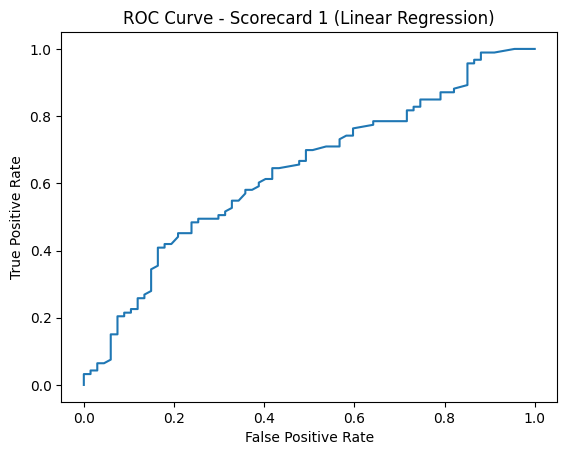

Gini coefficient for subset1 in Linear Regression:  0.27266891349703104
KS values for subset1 in Linear Regression:  0.24506499759268177


In [17]:
# Scorecard 1: Linear Regression (subset 1)
# Predicting probabilities on validation set
prob_lr_1 = LinearRegression_1.predict(X_valid_1[['Checking', 'Duration', 'Savings', 'Property']])
# Calculating false positive rate (fpr), true positive rate (tpr), and thresholds for ROC curve
fpr_lr_1, tpr_lr_1, thresholds_lr_1 = roc_curve(y_valid_1, prob_lr_1)
# Plotting ROC curve
plt.plot(fpr_lr_1, tpr_lr_1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Scorecard 1 (Linear Regression)')
plt.show()
# Calculating AUC
auc_lr_1 = roc_auc_score(y_valid_1, prob_lr_1)
# Calculating Gini coefficient and KS value
gini_lr_1 = 2 * auc_lr_1 - 1
ks_lr_1 = max(tpr_lr_1 - fpr_lr_1)
print('Gini coefficient for subset1 in Linear Regression: ',gini_lr_1)
print('KS values for subset1 in Linear Regression: ',ks_lr_1)

In [20]:
# Find the index of the threshold closest to 0.5
idx = np.argmin(np.abs(thresholds_lr_1 - 0.5))

# Calculate sensitivity and specificity for Scorecard 1
TP1 = tpr_lr_1[idx] * len(y_valid_1)
FP1 = fpr_lr_1[idx] * len(y_valid_1)
TN1 = (1 - fpr_lr_1[idx]) * len(y_valid_1)
FN1 = (1 - tpr_lr_1[idx]) * len(y_valid_1)
sensitivity_lr_1 = TP1 / (TP1 + FN1)
specificity_lr_1 = TN1 / (TN1 + FP1)

print('Sensitivity for Scorecard 1: ', sensitivity_lr_1)
print('Specificity for Scorecard 1: ', specificity_lr_1)

Sensitivity for Scorecard 1:  0.6989247311827957
Specificity for Scorecard 1:  0.5074626865671642


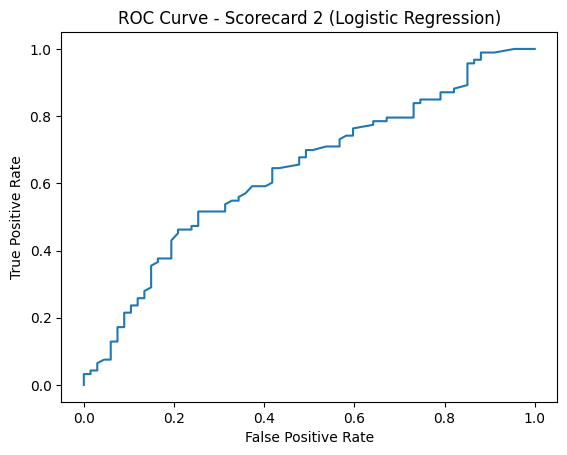

Gini coefficient for subset1 in Logistic Regression:  0.2739528165623495
KS values for subset1 in Logistic Regression:  0.2623976889744824


In [21]:
# Scorecard 2: Logistic Regression (subset 1)
# Predicting probabilities on validation set
prob_lor_1 = LogisticRegression_1.predict_proba(X_valid_1[['Checking', 'Duration', 'Savings', 'Property']])[:, 1]
# Calculating false positive rate (fpr), true positive rate (tpr), and thresholds for ROC curve
fpr_lor_1, tpr_lor_1, thresholds_lor_1 = roc_curve(y_valid_1, prob_lor_1)
# Plotting ROC curve
plt.plot(fpr_lor_1, tpr_lor_1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Scorecard 2 (Logistic Regression)')
plt.show()
# Calculating AUC
auc_lor_1 = roc_auc_score(y_valid_1, prob_lor_1)
# Calculating Gini coefficient and KS value
gini_lor_1 = 2 * auc_lor_1 - 1
ks_lor_1 = max(tpr_lor_1 - fpr_lor_1)
print('Gini coefficient for subset1 in Logistic Regression: ',gini_lor_1)
print('KS values for subset1 in Logistic Regression: ',ks_lor_1)

In [24]:
# Find the index of the threshold closest to 0.5
idx = np.argmin(np.abs(thresholds_lor_1 - 0.5))

# Calculate sensitivity and specificity for Scorecard 2
TP2 = tpr_lor_1[idx] * len(y_valid_1)
FP2 = fpr_lor_1[idx] * len(y_valid_1)
TN2 = (1 - fpr_lor_1[idx]) * len(y_valid_1)
FN2 = (1 - tpr_lor_1[idx]) * len(y_valid_1)
sensitivity_lor_1 = TP2 / (TP2 + FN2)
specificity_lor_1 = TN2 / (TN2 + FP2)

print('Sensitivity for Scorecard 2: ', sensitivity_lor_1)
print('Specificity for Scorecard 2: ', specificity_lor_1)

Sensitivity for Scorecard 2:  0.6989247311827957
Specificity for Scorecard 2:  0.5074626865671642


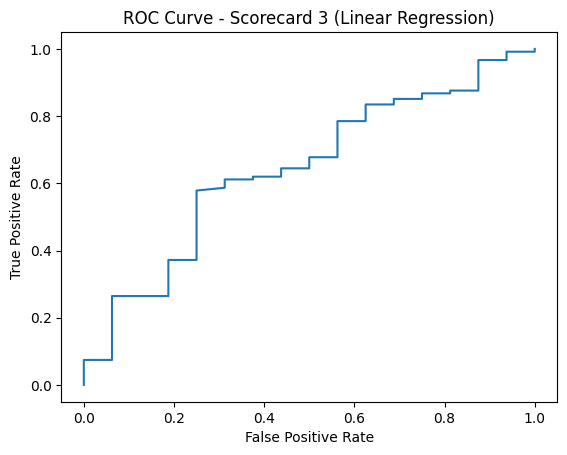

Gini coefficient for subset2 in Linear Regression:  0.28564049586776874
KS values for subset2 in Linear Regression:  0.32851239669421484


In [25]:
# Scorecard 3: Linear Regression (subset 2)
# Predicting probabilities on validation set
prob_lr_2 = LinearRegression_2.predict(X_valid_2[['Emploed', 'Age', 'History', 'Savings']])
# Calculating false positive rate (fpr), true positive rate (tpr), and thresholds for ROC curve
fpr_lr_2, tpr_lr_2, thresholds_lr_2 = roc_curve(y_valid_2, prob_lr_2)
# Plotting ROC curve
plt.plot(fpr_lr_2, tpr_lr_2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Scorecard 3 (Linear Regression)')
plt.show()
# Calculating AUC
auc_lr_2 = roc_auc_score(y_valid_2, prob_lr_2)
# Calculating Gini coefficient and KS value
gini_lr_2 = 2 * auc_lr_2 - 1
ks_lr_2 = max(tpr_lr_2 - fpr_lr_2)
print('Gini coefficient for subset2 in Linear Regression: ',gini_lr_2)
print('KS values for subset2 in Linear Regression: ',ks_lr_2)

In [26]:
# Find the index of the threshold closest to 0.5
idx = np.argmin(np.abs(thresholds_lr_2 - 0.5))

# Calculate sensitivity and specificity for Scorecard 2
TP = tpr_lr_2[idx] * len(y_valid_2)
FP = fpr_lr_2[idx] * len(y_valid_2)
TN = (1 - fpr_lr_2[idx]) * len(y_valid_2)
FN = (1 - tpr_lr_2[idx]) * len(y_valid_2)
sensitivity_lr_2 = TP / (TP + FN)
specificity_lr_2 = TN / (TN + FP)
print('Sensitivity for Scorecard 3 (Linear Regression): ', sensitivity_lr_2)
print('Specificity for Scorecard 3 (Linear Regression): ', specificity_lr_2)

Sensitivity for Scorecard 3 (Linear Regression):  1.0
Specificity for Scorecard 3 (Linear Regression):  0.0


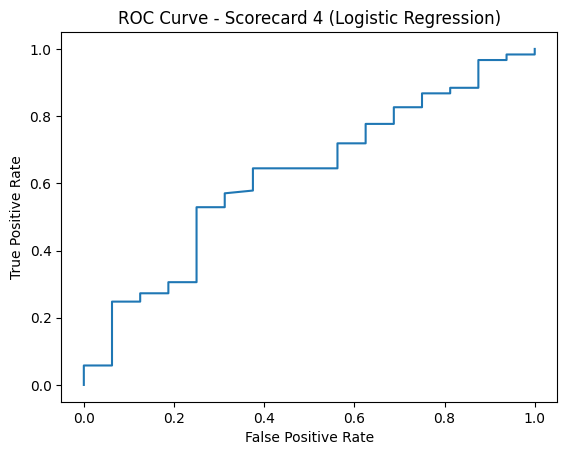

Gini coefficient for subset1 in Logistic Regression:  0.24328512396694224
KS values for subset1 in Logistic Regression:  0.27892561983471076


In [27]:
# Scorecard 4: Logistic Regression (subset 2)
# Predicting probabilities on validation set
prob_lor_2 = LogisticRegression_2.predict_proba(X_valid_2[['Emploed', 'Age', 'History', 'Savings']])[:, 1]
# Calculating false positive rate (fpr), true positive rate (tpr), and thresholds for ROC curve
fpr_lor_2, tpr_lor_2, thresholds_lor_2 = roc_curve(y_valid_2, prob_lor_2)
# Plotting ROC curve
plt.plot(fpr_lor_2, tpr_lor_2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Scorecard 4 (Logistic Regression)')
plt.show()
# Calculating AUC
auc_lor_2 = roc_auc_score(y_valid_2, prob_lor_2)
# Calculating Gini coefficient and KS value
gini_lor_2 = 2 * auc_lor_2 - 1
ks_lor_2 = max(tpr_lor_2 - fpr_lor_2)
print('Gini coefficient for subset1 in Logistic Regression: ',gini_lor_2)
print('KS values for subset1 in Logistic Regression: ',ks_lor_2)


In [28]:
# Find the index of the threshold closest to 0.5
idx = np.argmin(np.abs(thresholds_lor_2 - 0.5))

# Calculate sensitivity and specificity for Scorecard 4
TP = tpr_lor_2[idx] * len(y_valid_2)
FP = fpr_lor_2[idx] * len(y_valid_2)
TN = (1 - fpr_lor_2[idx]) * len(y_valid_2)
FN = (1 - tpr_lor_2[idx]) * len(y_valid_2)
sensitivity_lor_2 = TP / (TP + FN)
specificity_lor_2 = TN / (TN + FP)
print('Sensitivity for Scorecard 4 (Logistic Regression): ', sensitivity_lor_2)
print('Specificity for Scorecard 4 (Logistic Regression): ', specificity_lor_2)

Sensitivity for Scorecard 4 (Logistic Regression):  1.0
Specificity for Scorecard 4 (Logistic Regression):  0.0
